In [6]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # for plot color gradients
import glob
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.optimize import minimize, curve_fit, dual_annealing, differential_evolution, least_squares
import logging # to monitor optimizations
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter, landscape
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
import os
# Define the title for the entire PDF
pdf_title = "15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13"
# Define the base directory
base_dir = '/home/jwm/data/fluorescence_plots/'
# Construct the figure directory path
figure_dir = os.path.join(base_dir, pdf_title)
# Ensure the figure directory exists
os.makedirs(figure_dir, exist_ok=True)# Directory for joined pdfs
# Directory for joined pdfs
output_dir = '/home/jwm/data/fluorescence_plots/fluorescence_data_overview_21_may_2024/'
os.makedirs(output_dir, exist_ok=True)


In [2]:
# Load and organize data, set parameters and choose subset

# Set the directory where your data files are located
data_dir = '/home/jwm/data/JASCO_FP_6500_Spectrofluorometer/2024april13_50mM_DAB2_418_630_150mM_NaCl_1DCVJ_slow_hysteresis/'

start_temperature = 10

temperature_stepsize = 0.5



# Define the range of titles you want to load
# start_title = 7
# end_title = 30

# Function to load (x, y) data from txt file starting from the 19th line
def load_data(file_path):
    return np.loadtxt(file_path, skiprows=18)

# Get all txt files in the directory
data_files = glob.glob(data_dir + "*.txt")

# Initialize a list to store loaded data
loaded_data = []

# Initialize variables for baseline data
baseline_data = None
baseline_title = None

titles = []

# Load data and extract titles
for file_path in data_files:
    data = load_data(file_path)
    # Check if file name contains "999" and assign it as baseline data
    if "999" in file_path:
        baseline_data = data
    else:
        # Extract 6th to 4th last digits from file name and use as title
        title = int(file_path.split('/')[-1].split('.')[0][-7:-4])
        titles.append(title)
        loaded_data.append(data)
        
# Print the baseline title to check if it is set correctly
print("Baseline data loaded:", baseline_data is not None)

# Subtract the baseline spectrum from each spectrum if baseline_data is available
if baseline_data is not None:
    baseline_spectrum = baseline_data[:, 1]  # Assuming y-values are in the second column
    for i in range(len(loaded_data)):
        loaded_data[i][:, 1] -= baseline_spectrum

# Sort the titles and loaded_data in ascending order
sorted_indices = np.argsort(titles)
titles = [titles[i] for i in sorted_indices]
loaded_data = [loaded_data[i] for i in sorted_indices]

# Print sorted titles to verify sorting
print("Sorted titles:", titles)

# Convert extracted digits back to temperature values
temperatures = [start_temperature + i * temperature_stepsize for i in range(len(titles))]

# Extract x-values from the first spectrum in loaded_data
wavelengths = loaded_data[0][:, 0].astype(float)

print(wavelengths)

# Sample loaded_data structure
# loaded_data = [
#    np.array([[470.0, 422.133], [470.1, 422.08], [470.2, 422.001], [650.0, 7.49391]]),
#    np.array([[470.0, 430.678], [470.1, 430.75], [470.2, 430.611], [650.0, 7.97855]])
#]

# Function to create DataFrame
def create_dataframe(loaded_data, titles):  # spectra in rows
    # Initialize DataFrame with the first spectrum
    df = pd.DataFrame(loaded_data[0], columns=['wavelength', titles[0]])
    
    # Iterate over the remaining spectra and concatenate them to the DataFrame
    for i in range(1, len(loaded_data)):
        spectrum_df = pd.DataFrame(loaded_data[i], columns=['wavelength', titles[i]])
        df = pd.merge(df, spectrum_df, on='wavelength', how='outer')
    
    return df

# selected_data = [loaded_data[titles.index(title)] for title in included_titles]

title_inputs = input("Enter the titles to include (separated by space), and ranges separated by '-': ").split()
included_titles = [title for title_input in title_inputs for title in (list(range(int(title_input.split('-')[0]), int(title_input.split('-')[-1])+1)) if '-' in title_input else [int(title_input)])]

def get_selected_data(loaded_data, titles_input):
    selected_data = []
    selected_temperatures = []
    for title_input in titles_input:
        if '-' in str(title_input):
            start, end = map(int, title_input.split('-'))
            selected_data.extend(loaded_data[start-1:end])
            selected_temperatures.extend(temperatures[start-1:end])
        else:
            selected_data.append(loaded_data[int(title_input)-1])
            selected_temperatures.append(temperatures[int(title_input)-1])
    return selected_data, selected_temperatures
    
selected_data, selected_temperatures = get_selected_data(loaded_data, included_titles)

df = create_dataframe(selected_data, included_titles)
df = df.transpose()
print(df)



Baseline data loaded: True
Sorted titles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 100]
[470.  470.1 470.2 ... 649.8 649.9 650. ]


Enter the titles to include (separated by space), and ranges separated by '-':  1-45


               0        1        2        3        4        5        6     \
wavelength  470.000  470.100  470.200  470.300  470.400  470.500  470.600   
1           120.254  120.547  120.952  122.227  122.539  124.786  126.108   
2           128.799  129.217  129.562  130.126  131.033  132.968  134.314   
3           148.973  149.599  149.811  150.296  150.950  153.083  153.082   
4           179.545  179.431  179.918  180.942  181.789  183.595  184.277   
5           205.592  205.307  205.286  205.884  206.314  207.546  208.689   
6           225.090  225.038  225.668  225.446  225.762  227.169  228.132   
7           195.168  194.703  195.052  195.043  195.302  197.082  198.064   
8           198.170  198.196  198.376  198.953  198.193  199.976  200.440   
9           161.292  161.528  161.809  162.295  162.335  164.219  163.983   
10          118.461  117.889  117.955  118.942  118.885  120.209  121.335   
11           81.717   81.959   81.893   82.294   81.857   82.903   83.316   

In [ ]:
## Project onto Exponential and Lorentzians

# Lorentzian function
def lorentzian(x, d, x0, gamma):
    return d * gamma ** 2 / ((x - x0)**2 + gamma ** 2)

# Exponential function
def exponential(x, a, b, c):
    return a * np.exp(-b * (x - c))

# Initial guess for parameters
initial_d0 = 50 # 
initial_x0 = 490 # wavelengths.mean()  # Mean of the wavelengths
initial_gamma0 = (wavelengths.max() - wavelengths.min()) / 5  # Range of wavelengths divided by 10
inital_d1 = 10
initial_x1 = 505 # wavelengths.mean()  # Initial guess for the second Lorentzian's center
initial_gamma1 = (wavelengths.max() - wavelengths.min()) / 10  # Initial guess for the second Lorentzian's width
initial_a0 = 200.0  # Initial guess for the amplitude of the exponential
initial_b0 = -0.01  # Initial guess for the decay rate of the exponential
initial_c0 = 450 # wavelengths.mean()  # Initial guess for the center of the exponential
initial_a1 = 300.0  # Initial guess for the amplitude of the exponential
initial_b1 = -0.015  # Initial guess for the decay rate of the exponential
initial_c1 = 600 # wavelengths.mean()  # Initial guess for the center of the exponential
num_spectra = len(included_titles)
initial_scales = np.ones((4, num_spectra))  # Initial guess for scaling factors for each Lorentzian
initial_params = np.array([initial_d0, initial_x0, initial_gamma0, inital_d1, initial_x1, initial_gamma1, initial_a0, initial_b0, initial_c0, initial_a1, initial_b1, initial_c1] + initial_scales.flatten().tolist())

# Bounds for parameters
bounds = [
    (1, 100),     # bounds for d0
    (480, 500),   # bounds for x0
    (1, 100),     # bounds for gamma0
    (1, 100),     # bounds for d1
    (500, 520),   # bounds for x1
    (1, 100),     # bounds for gamma1
    (-50, 50),    # bounds for a0
    (-0.05, 0.01),# bounds for b0
    (300, 700),   # bounds for c0
    (-50, 50),    # bounds for a1
    (-0.08, 0.01),# bounds for b1
    (400, 800)    # bounds for c1
]
# Additional bounds for scaling factors for each function and spectrum
for _ in range(num_spectra):
    bounds.extend([
        (1, 50.0),   # Scaling factor for Lorentzian 1
    ])

for _ in range(num_spectra):
    bounds.extend([
        (1, 50.0),   # Scaling factor for Lorentzian 2
    ])

for _ in range(num_spectra):
    bounds.extend([
        (-50.0, 50.0),   # Scaling factor for Exponential 1
    ])

for _ in range(num_spectra):
    bounds.extend([
        (-50, 50.0)    # Scaling factor for Exponential 2
    ])

bound=np.array(bounds)

print(bounds)


# Callback function for verbosity
def callback(x, f, context):
    print(f"Current parameters: {x}")
    print(f"Objective function value: {f}")


# Filter the wavelengths and spectra to include only the range 475-525 nm
mask = (wavelengths >= 475) & (wavelengths <= 545)
filtered_wavelengths = wavelengths[mask]
filtered_spectra = df.iloc[:, mask]

def objective(params, df):
    d0, x0, gamma0, d1, x1, gamma1, a0, b0, c0, a1, b1, c1 = params[:12]
    scales = np.array(params[12:]).reshape((4, -1))
    residuals = []

    for i, title in enumerate(df.index[1:]):
        y_data = df.loc[title].values.astype(float)
        
        # Initialize y_fit with zeros for the full range of wavelengths
        y_fit = np.zeros_like(wavelengths)

        # Compute contributions for Lorentzian functions over filtered_wavelengths
        lorentzian1 = scales[0, i] * lorentzian(filtered_wavelengths, d0, x0, gamma0)
        lorentzian2 = scales[1, i] * lorentzian(filtered_wavelengths, d1, x1, gamma1)

        # Compute contributions for exponential functions over the full range of wavelengths
        exponential1 = scales[2, i] * exponential(wavelengths, a0, b0, c0)
        exponential2 = scales[3, i] * exponential(wavelengths, a1, b1, c1)

        # Apply Lorentzian contributions only where the wavelength is in the filtered range
        y_fit[mask] = lorentzian1 + lorentzian2

        # Apply exponential contributions to the entire wavelength range
        y_fit += exponential1 + exponential2

        # Compute residuals only for filtered wavelengths
        residuals.extend(y_data - y_fit[mask])

 # Calculate the sum of squared residuals
    sum_of_squares = np.sum(np.array(residuals)**2)
    
    # Print the sum of squared residuals for debugging
    print(f"Sum of squared residuals: {sum_of_squares:.4f}")

    return np.sum(np.square(residuals))

# Perform simulated annealing optimization


result = dual_annealing(objective, bounds,
    args=(filtered_spectra,),
    seed=42,  # Optional: for reproducibility
    maxiter=1000,  # Maximum number of iterations
    initial_temp=5230,  # Initial temperature
    visit=2.5,  # Controls the exploration of the parameter space
#    callback=callback  # Use the callback for verbosity
                       )

print(residuals)

# Extract the optimized parameters
optimized_d0 = result.x[0]
optimized_x0 = result.x[1]
optimized_gamma0 = result.x[2]
optimized_d1 = result.x[3]
optimized_x1 = result.x[4]
optimized_gamma1 = result.x[5]
optimized_a0 = result.x[6]
optimized_b0 = result.x[7]
optimized_c0 = result.x[8]
optimized_a1 = result.x[9]
optimized_b1 = result.x[10]
optimized_c1 = result.x[11]
optimized_scales = np.array(result.x[12:]).reshape((4, -1))  # Reshape scales into 2D array (2 rows, num_spectra columns)


# Output the results
print("Optimized d0 (Lorentzian 1):", optimized_d0)
print("Optimized x0 (Lorentzian 1):", optimized_x0)
print("Optimized gamma0 (Lorentzian 1):", optimized_gamma0)
print("Optimized d1 (Lorentzian 2):", optimized_d1)
print("Optimized x1 (Lorentzian 2):", optimized_x1)
print("Optimized gamma1 (Lorentzian 2):", optimized_gamma1)
print("Optimized a0 (Exponential):", optimized_a0)
print("Optimized b0 (Exponential):", optimized_b0)
print("Optimized c0 (Exponential):", optimized_c0)
print("Optimized a1 (Exponential):", optimized_a1)
print("Optimized b1 (Exponential):", optimized_b1)
print("Optimized c1 (Exponential):", optimized_c1)
print("Optimized scales:", optimized_scales)

[(1, 100), (480, 500), (1, 100), (1, 100), (500, 520), (1, 100), (-50, 50), (-0.05, 0.01), (300, 700), (-50, 50), (-0.08, 0.01), (400, 800), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 50.0), (

/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/9_projection_residuals.svg


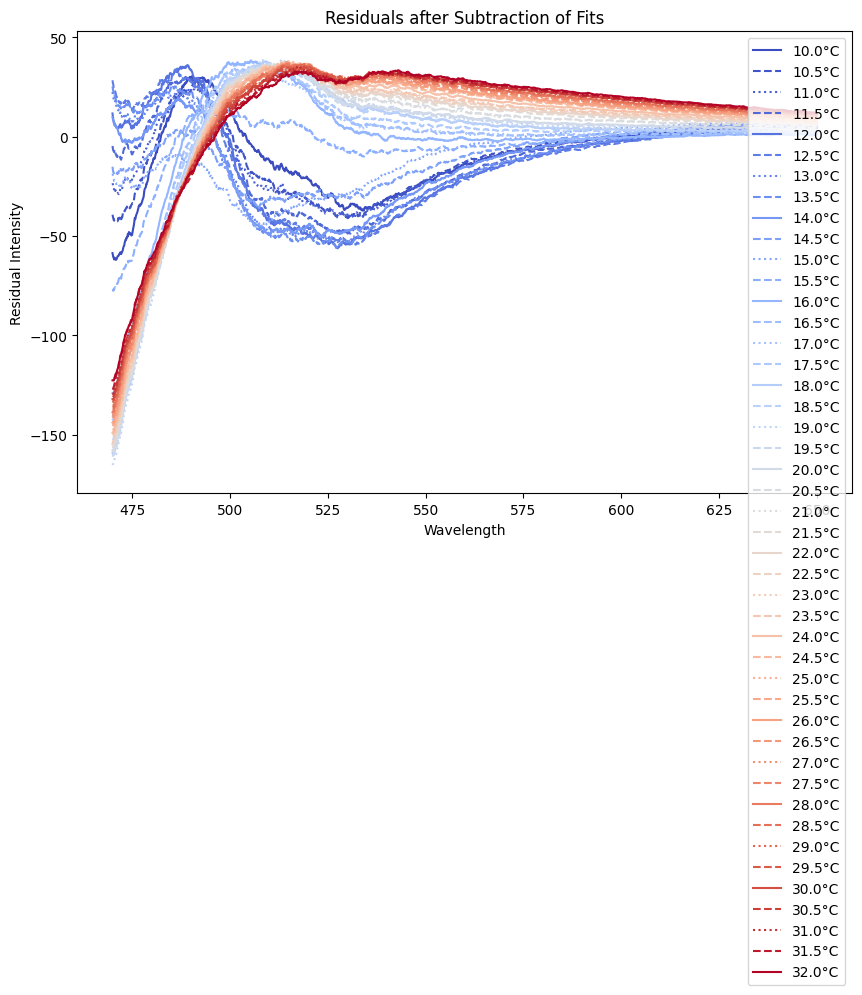

<module 'matplotlib.pyplot' from '/home/jwm/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [40]:
# Calculate the fitted curves and residues
fitted_curves = []
residues = []

for i, title in enumerate(df.index[1:]):
    y_data = df.loc[title].values.astype(float)  # Original spectral data
    y_fit = (optimized_scales[0, i] * lorentzian(wavelengths, optimized_d0, optimized_x0, optimized_gamma0) + 
             optimized_scales[1, i] * lorentzian(wavelengths, optimized_d1, optimized_x1, optimized_gamma1) + 
             optimized_scales[2, i] * exponential(wavelengths, optimized_a0, optimized_b0, optimized_c0)+ 
             optimized_scales[3, i] * exponential(wavelengths, optimized_a1, optimized_b1, optimized_c1))
    fitted_curves.append(y_fit)
    residues.append(y_data - y_fit)

# Calculate the global min and max of the residues
all_residues = np.concatenate(residues)
res_min = all_residues.min()
res_max = all_residues.max()

# Determine the 10% margin
margin = 0.07 * (res_max - res_min)
y_min = res_min - margin
y_max = res_max + margin

dotting_patterns=['-', '--', ':', '--']

# Plot the residuals for each spectrum
def plot_projection_residuals(wavelengths, residues, selected_temperatures):
    colormap = plt.get_cmap('coolwarm')  # Or use 'RdBu' or a custom colormap
    norm = mcolors.Normalize(vmin=min(selected_temperatures), vmax=max(selected_temperatures))
    
    plt.figure(figsize=(10, 6))
    for i, temp in enumerate(selected_temperatures):
        color = colormap(norm(temp))
        line_style = dotting_patterns[i % len(dotting_patterns)]  # Cycle through dotting patterns
        plt.plot(wavelengths, residues[i], label=f'{selected_temperatures[i]}°C', color=color, linestyle=line_style)
    
    plt.xlabel('Wavelength')
    plt.ylabel('Residual Intensity')
    plt.legend()
    plt.title(f'Residuals after Subtraction of Fits')
    plt.ylim(y_min, y_max)  # Set the y-axis limits
    save_path = os.path.join(figure_dir, '12_projection_residuals_sim_ann.svg')
    print(save_path)
    plt.savefig(save_path)    

    plt.show()
    return plt

plot_projection_residuals(wavelengths, residues, selected_temperatures)


/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/7_projected_functions.svg


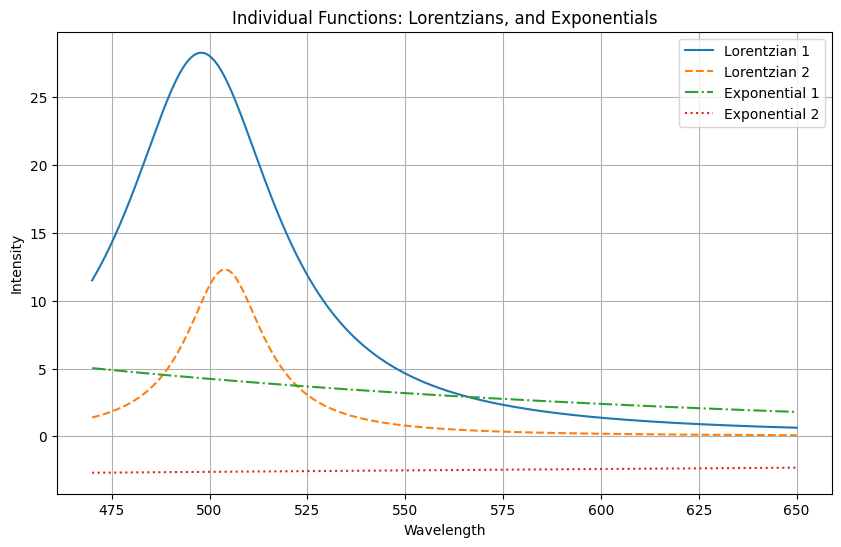

/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/8_scales_projected_functions.svg


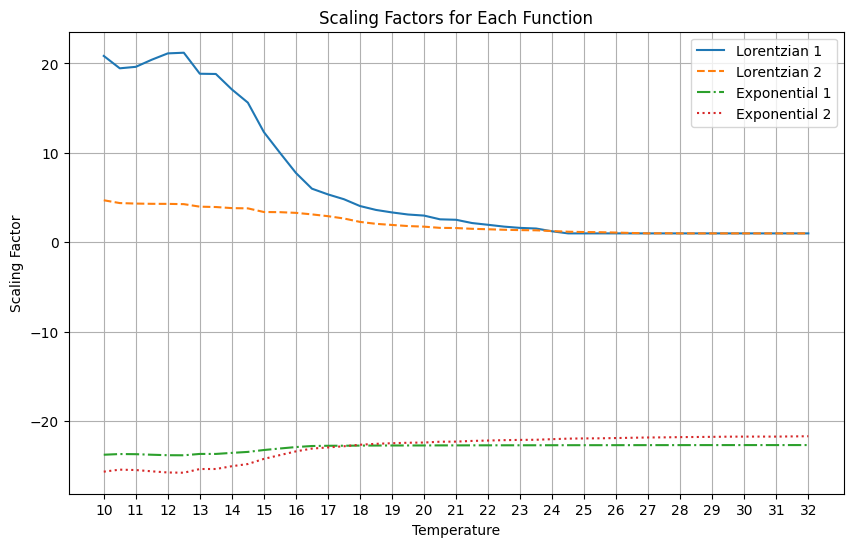

<module 'matplotlib.pyplot' from '/home/jwm/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [29]:
## Plot fitted functions and scaling factors

# Generate x values for plotting
x_values = np.linspace(wavelengths.min(), wavelengths.max(), 1000)

# Calculate the individual functions using the optimized parameters
lorentzian1_values = lorentzian(x_values, optimized_d0, optimized_x0, optimized_gamma0)
lorentzian2_values = lorentzian(x_values, optimized_d1, optimized_x1, optimized_gamma1)
exponential1_values = exponential(x_values, optimized_a0, optimized_b0, optimized_c0)
exponential2_values = exponential(x_values, optimized_a1, optimized_b1, optimized_c1)

def plot_fitted_functions(x_values, lorentzian1_values, lorentzian2_values, exponential1_values, exponential2_values):
# Plot the individual functions
    plt.figure(figsize=(10, 6))
# Plot Lorentzian 1
    plt.plot(x_values, lorentzian1_values, label='Lorentzian 1', linestyle='-')
# Plot Lorentzian 2
    plt.plot(x_values, lorentzian2_values, label='Lorentzian 2', linestyle='--')
# Plot Exponential 1
    plt.plot(x_values, exponential1_values, label='Exponential 1', linestyle='-.')
# Plot Exponential 2
    plt.plot(x_values, exponential2_values, label='Exponential 2', linestyle=':')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.title('Individual Functions: Lorentzians, and Exponentials')
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(figure_dir, '10_projected_functions_sim_ann.svg')
    print(save_path)
    plt.savefig(save_path)    

    plt.show()
    return plt
    
plot_fitted_functions(x_values, lorentzian1_values, lorentzian2_values, exponential1_values, exponential2_values)


# Get the number of spectra
num_spectra = len(df.index) - 1  # Exclude the first row (wavelengths)

# Extract the scaling factors for each function
scales_lorentzian1 = optimized_scales[0]
scales_lorentzian2 = optimized_scales[1]
scales_exponential1 = optimized_scales[2]
scales_exponential2 = optimized_scales[3]

# Plot the scaling factors for each function
def plot_projection_scaling_factors(selected_temperatures, scales_lorentzian1, scales_lorentzian2, scales_exponential1, scales_exponential2):
    plt.figure(figsize=(10, 6))

    plt.plot(selected_temperatures, scales_lorentzian1, linestyle='-', label='Lorentzian 1')
    plt.plot(selected_temperatures, scales_lorentzian2, linestyle='--', label='Lorentzian 2')
    plt.plot(selected_temperatures, scales_exponential1, linestyle='-.', label='Exponential 1')
    plt.plot(selected_temperatures, scales_exponential2, linestyle=':', label='Exponential 2')

    plt.xlabel('Temperature')
    plt.ylabel('Scaling Factor')
    plt.title('Scaling Factors for Each Function')
    plt.legend()
    plt.grid(True)
    plt.xticks(selected_temperatures[::2])
    save_path = os.path.join(figure_dir, '11_scales_projected_functions_sim_ann.svg')
    print(save_path)
    plt.savefig(save_path)    

    plt.show()
    return plt

plot_projection_scaling_factors(selected_temperatures, scales_lorentzian1, scales_lorentzian2, scales_exponential1, scales_exponential2)